In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product

tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":4,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
    'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
    "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    
%config InlineBackend.close_figures=False # keep figures open in pyplot
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':"tight", 'pad_inches':2}

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4cm": "g", 
          "4em": "m", 
          "Donor":"#a4e0ef", 
          "Host":"#ff7f0e",
         "WT":"#02feff",
         "Young CHIM":"#008080",
         "Old CHIM":"None"}

my_marks = {"Donor": "o",#"$\circ$", 
           "Host": "^",
         "WT":"o",
         "Young CHIM":"P",
         "Old CHIM":"^"}


scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':'k',

                
}

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

df = pd.read_csv('/home/elise/Code/BRDU/Elisehasbeenusing_dataUCL.csv',index_col='index')
df['age_cat']=np.where(df.age < 114, 'WT', np.where((df.age >= 114) & (df.age < 180), 'Young CHIM', 'Old CHIM'))

df['ADH'] = df['ADH'].replace('donor','Donor')
df['ADH'] = df['ADH'].replace('host','Host')

In [2]:
# def myMAP_CI(datad, datah):


#     arrayedd = datad.to_numpy()
#     nparam_densityd = sts.kde.gaussian_kde(arrayedd)
#     xd = np.linspace(np.min(arrayedd), np.max(arrayedd), 2000)
#     nparam_densityd = nparam_densityd(xd)

#     lA_calcd, uA_calcd = np.percentile(datad, q=[5, 95])
    
#     arrayedh = datah.to_numpy()
#     nparam_densityh = sts.kde.gaussian_kde(arrayedh)
#     xh = np.linspace(np.min(arrayedh), np.max(arrayedh), 2000)
#     nparam_densityh = nparam_densityh(xh)

#     lA_calch, uA_calch = np.percentile(datah, q=[5, 95])
    
    
#     return [xd[np.argsort(nparam_densityd)[-1]],  lA_calcd, uA_calcd, xh[np.argsort(nparam_densityh)[-1]],  lA_calch, uA_calch] 


def myMAP_CI(datad, datah):


    arrayedd = datad.to_numpy()
    mediand = np.median(arrayedd)

    lA_calcd, uA_calcd = np.percentile(datad, q=[5, 95])
    
    arrayedh = datah.to_numpy()
    medianh = np.median(arrayedh)


    lA_calch, uA_calch = np.percentile(datah, q=[5, 95])
    
    
    return [mediand,  lA_calcd, uA_calcd, medianh,  lA_calch, uA_calch] 


def myMAP(data):

    arrayed = data.to_numpy()
    nparam_density = sts.kde.gaussian_kde(arrayed)
    x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
    nparam_density = nparam_density(x)

    return x[np.argsort(nparam_density)[-1]]


from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'ADH'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['age_cat'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
        print("Mann Whitney Ustat calculated p:",
              pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
    print("pvalues:", pvalues)
    
    return pvalues

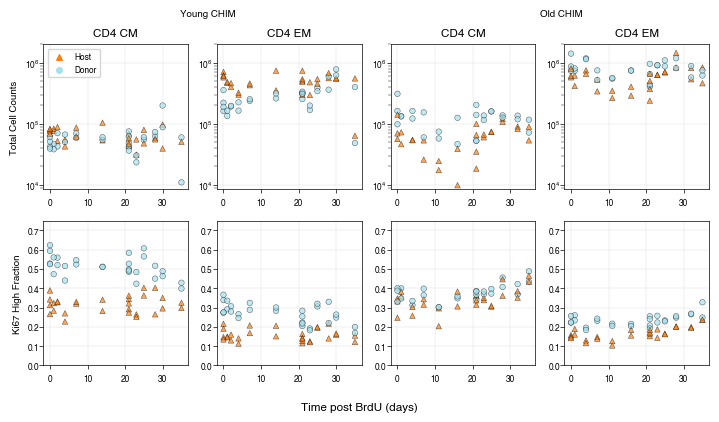

In [3]:
df = df.sort_values('age')

dfold = df[(df['kind'] == 'chimera')&(df['ADH'] != 'all')]

fig = plt.figure(figsize=(7.2,4),tight_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)


    
spec1 = spec[0,0].subgridspec(ncols=2, nrows=1,**kwags)


popc='4cm'
ax1 = fig.add_subplot(spec1[0])

sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Young CHIM')], x="expt_time",
            y="Qall", hue='ADH',ax=ax1, style='ADH', alpha = 0.7, **scatterkwags)
ax1.set_title('CD4 CM')
ax1.set_ylabel('Total Cell Counts')
ax1.set_yscale('log')
ax1.set_ylim(8.5E3,.2e7)

ax1.set_box_aspect(1)
ax1.set_axisbelow(True)
ax1.legend_.set_title(None)
ax1.set_xlabel('')

# Place the legend
lgd = ax1.legend(
    loc="upper left", 
    title=None
)
# Modify the point edge colour
# for ha in ax1.legend_.legendHandles[0:2]:
#     ha.set_edgecolor("black")
    
    

popc='4em'
ax = fig.add_subplot(spec1[1],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Young CHIM')], x="expt_time",
            y="Qall", hue='ADH',ax=ax, style='ADH',alpha = 0.7, **scatterkwags, legend=False)
ax.set_title('CD4 EM')
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.set_xlabel('')

spec3 = spec[0,1].subgridspec(ncols=2, nrows=1,**kwags)

popc='4cm'
ax = fig.add_subplot(spec3[0],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Old CHIM')], x="expt_time",
            y="Qall", hue='ADH',ax=ax, style='ADH',alpha = 0.7,**scatterkwags, legend=False)
ax.set_title('CD4 CM')
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.set_xlabel('')

popc='4em'
ax = fig.add_subplot(spec3[1],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Old CHIM')], x="expt_time",
            y="Qall", hue='ADH',ax=ax, style='ADH',alpha = 0.7,**scatterkwags, legend=False)
ax.set_ylabel('')
ax.set_title('CD4 EM')
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_xlabel('')





spec2 = spec[1,0].subgridspec(ncols=2, nrows=1, **kwags)


popc='4cm'
ax1 = fig.add_subplot(spec2[0])

sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Young CHIM')], x="expt_time",
            y="Ki67frac", hue='ADH',ax=ax1, style='ADH',alpha = 0.7, **scatterkwags, legend=False)
ax1.set_ylabel('Ki67 High Fraction')
ax1.set_ylim(0,0.75)

ax1.set_box_aspect(1)
ax1.set_axisbelow(True)
ax1.set_xlabel('')

    

popc='4em'
ax = fig.add_subplot(spec2[1],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Young CHIM')], x="expt_time",
            y="Ki67frac", hue='ADH',ax=ax, style='ADH',alpha = 0.7, **scatterkwags, legend=False)
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.set_xlabel('')
spec3 = spec[1,1].subgridspec(ncols=2, nrows=1,**kwags)

popc='4cm'
ax = fig.add_subplot(spec3[0],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Old CHIM')], x="expt_time",
            y="Ki67frac", hue='ADH',ax=ax, style='ADH',alpha = 0.7,**scatterkwags, legend=False)
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.set_xlabel('')

popc='4em'
ax = fig.add_subplot(spec3[1],sharex=ax1, sharey=ax1)
sns.scatterplot(data = dfold[(dfold['population'] == popc)&(dfold['age_cat']=='Old CHIM')], x="expt_time",
            y="Ki67frac", hue='ADH',ax=ax, style='ADH',alpha = 0.7,**scatterkwags, legend=False)
ax.set_ylabel('')
ax.set_box_aspect(1)
ax.set_axisbelow(True)
ax.set_xlabel('')

fig.text(0.25,1,'Young CHIM')
fig.text(0.75,1,'Old CHIM')
fig.supxlabel('Time post BrdU (days)')

fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/figS1.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

# fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig2png.png', dpi='figure', format='png',
#         bbox_inches='tight', pad_inches=0.1)